# Notebook for single trial PCA
## single reach control trials only (no laser), 50ms before lift to 300ms after behavior ends (assuming 260ms for at mouth)
## 5ms/10ms/20ms time bins
## Applying Kalman filter (Q=1e-3, no baseline firing rate)

In [1]:
from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import fastplotlib as fpl
from tqdm import tqdm

fastplotlib version from git (0.5.0) and __version__ (0.5.1) don't match.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


Image(value=b'version https://git-lfs.github.com/spec/...', height='55', width='300')

Valid,Device,Type,Backend,Driver
✅,Intel(R) Arc(tm) Graphics (MTL),IntegratedGPU,Vulkan,Mesa 25.0.4
✅ (default),NVIDIA GeForce RTX 4060 Laptop GPU,DiscreteGPU,Vulkan,565.77
❗ limited,"llvmpipe (LLVM 19.1.7, 256 bits)",CPU,Vulkan,Mesa 25.0.4 (LLVM 19.1.7)
❌,Mesa Intel(R) Arc(tm) Graphics (MTL),IntegratedGPU,OpenGL,4.6 (Core Profile) Mesa 25.0.4


Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


In [2]:
mat = loadmat("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt2.mat")
mat = mat['data']

print(type(mat))        # <class 'numpy.ndarray'>
print(mat.dtype.names)

<class 'numpy.ndarray'>
('totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success')


In [3]:
data_struct = mat[0, 0]  # MATLAB structs are 2D arrays even if 1x1
data = {field: data_struct[field] for field in mat.dtype.names}

In [4]:
data.keys()

dict_keys(['totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success'])

# Visualize the patterns

In [5]:
# visualize the patterns again
pattern_ids = list(np.unique(data['pattern_id']))
len(pattern_ids)

30

In [6]:
#reshape_size = 12
pattern_ids = list(np.unique(data['pattern_id']))
all_patterns = list()
# pattern 0 = no laser
all_patterns.append(np.zeros((12, 12)))
# pattern 1 = full field
all_patterns.append(np.ones((12, 12)))
# pattern 2 = empty field 
all_patterns.append(np.zeros((12, 12)))
for p_id in pattern_ids[3:]:
    ix = np.where(data['pattern_id'] == p_id)[0][0].astype(np.int32)
    pattern = np.zeros((data['pattern_xy'][ix][0].astype(np.int32), data['pattern_xy'][ix][1].astype(np.int32)))
    # use the pattern fill to set elements to one
    object_ref = data['pattern_fill'][0][ix]
    for x, y in zip(object_ref[:, 0], object_ref[:, 1]):
        pattern[x.astype(np.int32)-1, y.astype(np.int32)-1] = 1

    all_patterns.append(pattern)

    #pattern = zoom(pattern, (reshape_size / pattern.shape[0], reshape_size / pattern.shape[1]), order=0)

    #interp_patterns.append(pattern)

In [7]:
len(all_patterns)

30

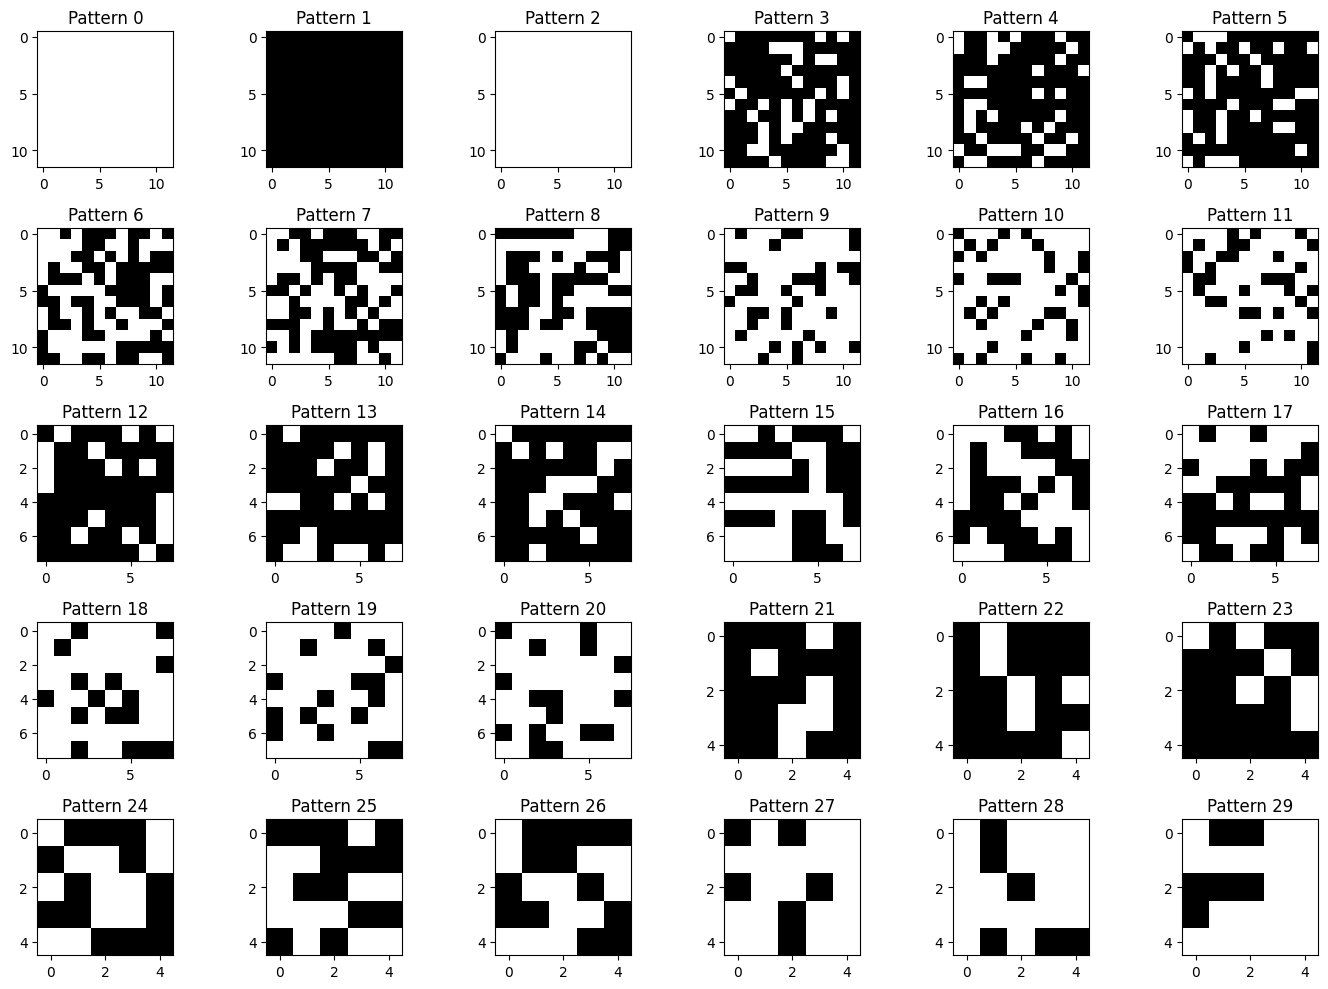

In [8]:
fig, axes = plt.subplots(5, 6, figsize=(14, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, array in zip(range(len(all_patterns)), all_patterns):
    ax = axes[i]
    ax.imshow(array, cmap="binary", vmin=0, vmax=1)

    ax.set_title(f"Pattern {i}") 

#plt.gca().invert_yaxis() 
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Get single-reach control trials

In [9]:
# get no laser trials
control_idxs = np.where(data["pattern_id"][:150] == 0)[0] 

In [10]:
# get blank pattern trials
#b = np.where(data["pattern_id"][:150] == 2)[0]

In [11]:
#control_idxs = np.sort(np.concatenate((a, b)))
control_idxs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  21,  27,  33,  39,  45,  51,  57,  63,  69,  75,
        81,  87,  93,  99, 105, 111, 117, 123, 129, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149])

### Only want to look at single reach trials

In [12]:
single_idxs = np.where(data["single"] == 1)[1]
single_idxs

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  12,  14,  15,
        16,  17,  18,  19,  20,  21,  23,  24,  26,  30,  33,  36,  37,
        38,  39,  40,  41,  43,  44,  45,  46,  48,  49,  50,  51,  52,
        53,  54,  58,  60,  61,  62,  63,  67,  68,  69,  70,  71,  73,
        74,  77,  78,  81,  82,  84,  85,  88,  89,  91, 105, 107, 109,
       116, 117, 121, 122, 130, 137, 139, 145, 148])

In [13]:
control_idxs = np.intersect1d(control_idxs, single_idxs)
control_idxs

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  12,  14,  15,
        21,  33,  39,  45,  51,  63,  69,  81, 105, 117, 137, 139, 145,
       148])

In [14]:
control_idxs.shape

(27,)

## Get relevant time information

In [15]:
cue_times = data["cue_rec_time"][:, :150]
cue_times[:, control_idxs]

array([[  14310.86566601,   31635.98602851,   66118.75767016,
          83391.57934485,  100671.38676484,  117878.88228075,
         135202.39780987,  152469.08335693,  169748.98517889,
         187076.46559048,  221580.66647786,  256113.84876805,
         343834.9853677 ,  447413.10299254,  654737.65694326,
         758001.60483338,  861313.50892099,  964758.89738507,
        1172344.18955914, 1276101.01010101, 1483298.49900878,
        1897560.18125177, 2104905.22042859, 2466558.2932125 ,
        2501046.72897196, 2604792.2212782 , 2656431.70017936]])

In [16]:
lift_times = data["lift_ms"][:, :150]
lift_times[:, control_idxs]

array([[310., 280., 330., 320., 300., 250., 270.,  90., 260., 260., 230.,
        230., 310., 220., 230., 290., 280., 250., 270., 300., 280., 300.,
        200., 290., 340., 250., 220.]])

In [17]:
mouth_times = data["mouth_ms"][:, :150]
mouth_times[:, control_idxs]

array([[540., 540., 560., 570., 520., 540., 600., 460., 510., 490., 500.,
        530., 510., 510., 490., 590., 520., 530., 620., 510., 520., 570.,
        560., 530., 570., 590., 480.]])

## Get the AP.bin file

In [18]:
from real_spike.utils import get_sample_data, get_meta
import tifffile

In [19]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.meta")

In [20]:
meta_data = get_meta(meta_path)

In [21]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 166298223)

## Get conversion params

In [22]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

In [23]:
vmax

0.6

In [24]:
imax

512.0

In [25]:
gain

500.0

## Get first trial

#### 50ms before "lift" to 300ms after behavior

In [26]:
trial_no = 0

In [27]:
# get the lift time in ap units 
# cue + lift time (ms) / 1000 = s * 30_000 (sR) 
lift_time = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)
lift_time

# get end of behavior = mouth (260ms) + 300ms 
end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260 + 300) / 1_000 * 30_000)
(lift_time, end_behavior)

(437125, 462325)

In [28]:
trial_one = ap_data[:150, lift_time:end_behavior]
trial_one.shape

(150, 25200)

## Convert to microvolts 

In [29]:
conv_data = 1e6 * trial_one / vmax / imax / gain

In [30]:
conv_data.shape

(150, 25200)

## Filter

In [31]:
from real_spike.utils import butter_filter

In [32]:
filt_data = butter_filter(conv_data, 1_000, 30_000)
filt_data.shape

(150, 25200)

## Median/MAD Threshold 

In [33]:
from real_spike.utils import get_spike_events

In [34]:
median = np.median(filt_data, axis=1)
median.shape

(150,)

In [35]:
spike_ixs, counts = get_spike_events(filt_data, median)

In [36]:
# create a range of the entire trial time
# binarize the spike times
# bin into 5ms bins (every 150 data points) 

In [37]:
a = np.zeros((filt_data.shape[0], filt_data.shape[1]))

In [38]:
for i, sc in enumerate(spike_ixs):
    a[i, sc] = 1

## Bin the spike data

In [39]:
def bin_spike_data(spikes, bin_size):
    n_channels, n_timepoints = spikes.shape
    n_bins = n_timepoints // bin_size  # drop remainder
 #   print(n_bins)
    spikes = spikes[:, :n_bins * bin_size]  # truncate to fit bins

    # Reshape and sum
    binned = spikes.reshape(n_channels, n_bins, bin_size).sum(axis=2)
    return binned

In [40]:
bin_size = 20 # 10ms * 30 points per 1ms

In [41]:
b = bin_size * 30
binned_spikes = bin_spike_data(a, bin_size=b)

In [42]:
binned_spikes.shape

(150, 42)

## Apply kalman filter

In [43]:
import numpy as np
from filterpy.kalman import KalmanFilter

def apply_kalman_filter(data, A=1, H=1, Q=1e-2, R=1, initial_state=None):
    """
    Applies 1D Kalman filter to each channel in the binned spike data.

    Args:
        data (ndarray): Shape (n_channels, n_time_bins)
        A: State transition
        H: Observation model
        Q: Process noise
        R: Measurement noise
        initial_state: Optional starting value per channel

    Returns:
        ndarray: Smoothed data of same shape
    """
    n_channels, n_time = data.shape
    smoothed = np.zeros_like(data, dtype=float)

    for ch in range(n_channels):
        kf = KalmanFilter(dim_x=1, dim_z=1)
        kf.F = np.array([[A]])     # State transition matrix
        kf.H = np.array([[H]])     # Observation matrix
        kf.Q = np.array([[Q]])     # Process noise covariance
        kf.R = np.array([[R]])     # Measurement noise covariance
        kf.x = np.array([[initial_state[ch] if initial_state else data[ch, 0]]])  # Initial state
        kf.P = np.eye(1) * 1       # Initial covariance

        for t in range(n_time):
            kf.predict()
            kf.update(np.array([[data[ch, t]]]))
            smoothed[ch, t] = kf.x[0, 0]

    return smoothed

In [44]:
#binned = np.random.poisson(0.5, (4, 100))  # fake binned data
smoothed = apply_kalman_filter(binned_spikes)


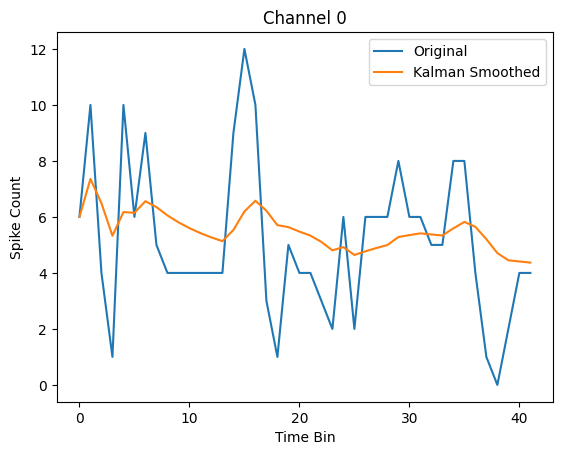

In [45]:
import matplotlib.pyplot as plt

plt.plot(binned_spikes[0], label='Original')
plt.plot(smoothed[0], label='Kalman Smoothed')
plt.legend()
plt.title('Channel 0')
plt.xlabel('Time Bin')
plt.ylabel('Spike Count')
plt.show()


In [46]:
from sklearn.decomposition import PCA

In [47]:
pca = PCA(n_components=6)

# Fit the PCA model to the data and transform the data
pca.fit(smoothed.T)
reduced_data = pca.transform(smoothed.T)

print("Explained variance ratio by each principal component:", pca.explained_variance_ratio_)

Explained variance ratio by each principal component: [0.81135707 0.08102206 0.04241824 0.01753819 0.01186617 0.00999275]


In [48]:
reduced_data.shape

(42, 6)

In [49]:
smoothed.shape

(150, 42)

In [50]:
# lift/grab/mouth

In [51]:
# 50 ms before lift = 10 bins 
# 300 ms after mouth = 60 bins

In [52]:
# lift duration
lift = int(data["lift_ms"][0,trial_no] / bin_size) 
# grab duration
grab = int(data["grab_ms"][0,trial_no] / bin_size)
# mouth duration 
mouth = int(data["mouth_ms"][0,trial_no] / bin_size)

(lift, grab, mouth)

(15, 21, 27)

Explained variance ratio by each principal component: [0.81135707 0.08102206 0.04241824 0.01753819 0.01186617 0.00999275]


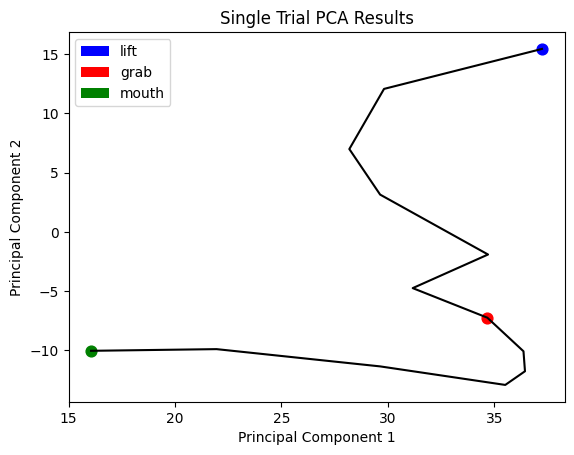

In [53]:
# Print explained variance ratio
print("Explained variance ratio by each principal component:", pca.explained_variance_ratio_)

lift_start = int(50 / bin_size)
mouth_start = lift_start + (mouth-lift)

# # Visualize the reduced data (scatter plot)
plt.plot(reduced_data[lift_start:mouth_start+1, 0], reduced_data[lift_start:mouth_start+1, 1], c="black")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Single Trial PCA Results")

plt.scatter(reduced_data[lift_start, 0], reduced_data[lift_start, 1], s=60, c="blue")
plt.scatter(reduced_data[grab - lift + lift_start, 0], reduced_data[grab-lift +lift_start, 1], s=60, c="red")
plt.scatter(reduced_data[mouth_start, 0], reduced_data[mouth_start, 1], s=60, c="green")

from matplotlib.patches import Patch

# Sample color mapping
c = {'lift': 'blue', 'grab': 'red', 'mouth': 'green'}

# Manual legend
legend_elements = [Patch(facecolor=color, label=beh) for beh, color in c.items()]
plt.legend(handles=legend_elements)
plt.show()

In [75]:
all_data = list()
#explained_variances = list()

# HYPERPARAMETERS TO TOGGLE
bin_size = 50
Q=1e-3

for i in tqdm(control_idxs):
    trial_no = i
    # get time points in ap space
    lift_time = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)
    
    # get end of behavior = mouth (260ms) + 300ms 
    end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260 + 300) / 1_000 * 30_000)
    #print(lift_time, end_behavior)

    trial = ap_data[:150, lift_time:end_behavior]

    conv_data = 1e6 * trial / vmax / imax / gain

    filt_data = butter_filter(conv_data, 1_000, 30_000)

    median = np.median(filt_data, axis=1)

    spike_ixs, counts = get_spike_events(filt_data, median)
    
    a = np.zeros((filt_data.shape[0], filt_data.shape[1]))

    for i, sc in enumerate(spike_ixs):
        a[i, sc] = 1

    b = bin_size * 30 # 30ms per bin
    binned_spikes = bin_spike_data(a, b)

    smoothed = apply_kalman_filter(binned_spikes, Q=Q)

    all_data.append(smoothed)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:08<00:00,  3.33it/s]


In [76]:
pca = PCA(n_components=6)

d = np.concatenate(all_data, axis=1)

    # Fit the PCA model to the data and transform the data
pca.fit(d.T)
    # reduced_data = pca.transform(smoothed.T)

    # pcas.append(reduced_data)
pca.explained_variance_ratio_

array([0.40652938, 0.13820101, 0.07282855, 0.04918994, 0.03793324,
       0.02729554])

In [77]:
pca.explained_variance_ratio_.sum()

0.7319776516561932

In [78]:
def get_trial_PCA(trial, pca):
    X = trial.T

    total_var = np.var(X, axis=0).sum()

    proj = pca.transform(X)

    pc_vars = np.var(proj[:, :3], axis=0)

    explained = pc_vars / total_var

    return explained, proj

In [79]:
from scipy.ndimage import gaussian_filter1d

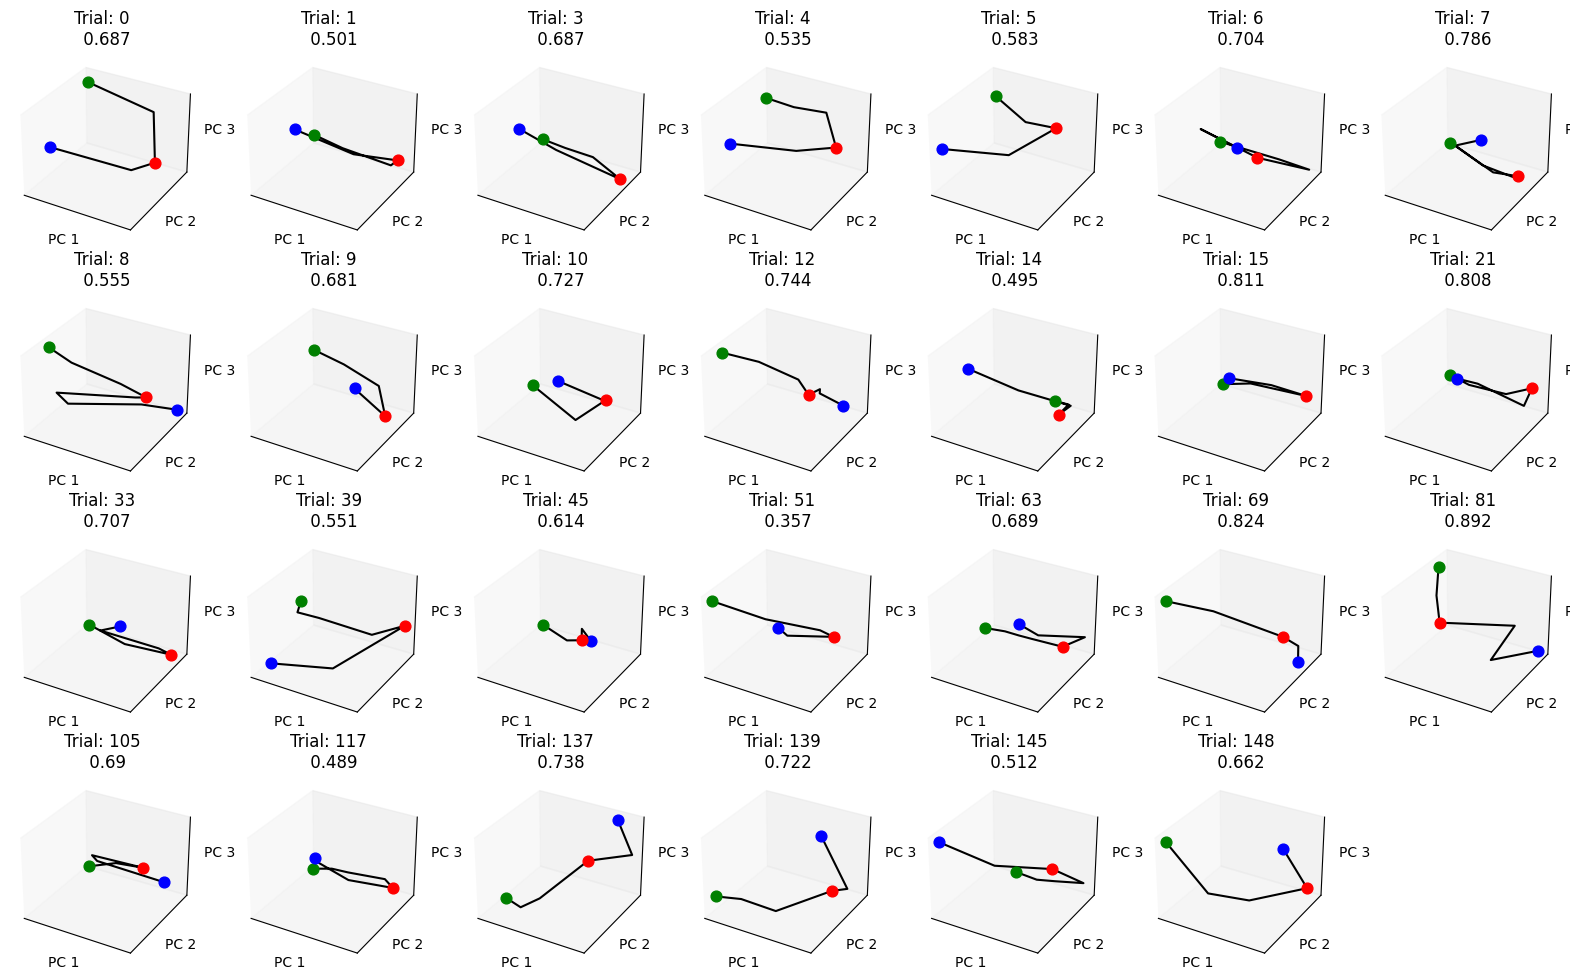

In [82]:
fig, axes = plt.subplots(4, 7, figsize=(20, 12), subplot_kw=dict(projection='3d'))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, p in enumerate(all_data):

    explained_var, p = get_trial_PCA(p, pca)
    
    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
    mouth_start = lift_start + (mouth-lift)

    # p = gaussian_filter1d(p, sigma=0.05)
    #p = gaussian_filter1d(p, sigma=1, axis=0)

    #axes[i].scatter(p[:, 0], p[:, 1], s=1, c=colors)
    axes[i].plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], p[lift_start:mouth_start+1, 2], c="black")
    axes[i].set_xlabel(f"PC 1", labelpad=-7)
    axes[i].set_ylabel(f"PC 2", labelpad=-7)
    axes[i].set_zlabel(f"PC 3", labelpad=-7)
    axes[i].set_title(f"Trial: {control_idxs[i]} \n {round(explained_var.sum(), 3)}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_zticks([])


    axes[i].scatter(p[lift_start, 0], p[lift_start, 1], p[lift_start, 2], s=60, c="blue")
    axes[i].scatter(p[grab_start, 0], p[grab_start, 1], p[grab_start, 2], s=60, c="red")
    axes[i].scatter(p[mouth_start, 0], p[mouth_start, 1], p[mouth_start, 2], s=60, c="green")

axes[-1].remove() 

plt.savefig(f'/home/clewis/repos/realSpike/data/rb50_20250127/PCA_control_{bin_size}ms.png')